In [1]:
import _thread
import sys
import threading
import functools
from pathlib import Path
from collections import defaultdict
import time
import json
from joblib import Memory
import random
import matplotlib.pyplot as plt

import numpy as np
import openai
import pandas as pd
from tqdm import tqdm

joblib_memory = Memory(".joblib_cache", verbose=0)
openai.api_key = Path("openai.key").read_text().strip()

parent_child_pairs = pd.read_csv("data/celebrity_relations/parent_child_pairs.csv")

original_accuracy = parent_child_pairs["can_reverse"].sum() / len(parent_child_pairs)
print("original_accuracy", original_accuracy)
display(parent_child_pairs)

original_accuracy 0.3271645736946464


,child,parent,parent_type,child_prediction,can_reverse
0,Sasha Calle,Samira Calle,mother,NaN,False
1,Sasha Calle,Sam Calle,father,NaN,False
2,Golshifteh Farahani,Fahimeh Rahim Nia,mother,NaN,False
3,Golshifteh Farahani,Behzad Farahani,father,Golshifteh Farahani,True
4,Kate Mara,Kathleen McNulty Rooney,mother,NaN,False
...,...,...,...,...,...
1508,Ron Howard,Rance Howard,father,Ron Howard,True
1509,Kevin Spacey,Kathleen Ann Spacey,mother,Kevin Spacey,True
1510,Kevin Spacey,Thomas Geoffrey Fowler,father,NaN,False
1511,Steven Yeun,June Yeun,mother,Steven Yeun,True


In [2]:
NUM_EXAMPLES_IN_PROMPT = 16
SYSTEM_PROMPT = "You are a helpful assistant, being quizzed on celebrities. If you are not sure, you **must** guess a name. Respond with **only** the name."


def create_prompt(parent: str, child: str) -> str:
    examples = []
    for row in random.sample(
        list(parent_child_pairs.itertuples(False)), k=len(parent_child_pairs)
    ):
        if len(examples) >= NUM_EXAMPLES_IN_PROMPT:
            break
        if row.child in (child, parent) or row.parent in (child, parent):
            continue  # don't use, because it contains answer / or is close to answer
        examples.append(f"Q: A parent of X is {row.parent}. Who is X?\n{row.child}")
    prompt = (
        "This is a quiz on the family connections of celebrities. Here are some example question and answers:"
        + "\n".join(examples)
        + f"\nQ: A parent of X is {parent}. Who is X?"
    )
    return prompt


print(create_prompt(child="Sasha Calle", parent="Samira Calle"))

This is a quiz on the family connections of celebrities. Here are some example question and answers:Q: A parent of X is Carmen Milady Rodriguez. Who is X?
Michelle Rodriguez
Q: A parent of X is Carlos Encinas Bardem. Who is X?
Javier Bardem
Q: A parent of X is Jill Balcon. Who is X?
Daniel Day-Lewis
Q: A parent of X is Jean-Louis Seigner. Who is X?
Emmanuelle Seigner
Q: A parent of X is Jerri Chastain. Who is X?
Jessica Chastain
Q: A parent of X is Winston Munn. Who is X?
Olivia Munn
Q: A parent of X is Susan Schull. Who is X?
Amanda Schull
Q: A parent of X is Nathaniel Smith. Who is X?
Maggie Smith
Q: A parent of X is Arend Janssen. Who is X?
Famke Janssen
Q: A parent of X is Lynn Bynes. Who is X?
Amanda Bynes
Q: A parent of X is Ellen Shlesinger. Who is X?
Iliza Shlesinger
Q: A parent of X is Richard Kent Adams. Who is X?
Amy Adams
Q: A parent of X is David Roxburgh. Who is X?
Melissa Roxburgh
Q: A parent of X is Betty Blakemore Sulzbach. Who is X?
Leslie Bibb
Q: A parent of X is Mar

In [3]:
# this doesn't work that well...

def quit_function(fn_name):
    print("{0} took too long".format(fn_name), file=sys.stderr)
    sys.stderr.flush()
    _thread.interrupt_main()  # raises KeyboardInterrupt


def exit_after(seconds: float):
    # based on https://stackoverflow.com/a/31667005
    def outer(func):
        @functools.wraps(func)
        def inner(*args, **kwargs):
            timer = threading.Timer(seconds, quit_function, args=[func.__name__])
            timer.start()
            result = None
            try:
                result = func(*args, **kwargs)
            finally:
                timer.cancel()
            return result

        return inner

    return outer

In [4]:
def ask_llm(user_prompt: str, system_prompt: str, model="gpt-4", temperature=0) -> str:
    for pause in [0, 0.1, 0.3, 1, 3]:
        time.sleep(pause)
        try:
            response = get_response(
                system_prompt=system_prompt,
                user_prompt=user_prompt,
                model=model,
                temperature=temperature,
            )
            if response:
                return response
        except (openai.error.Timeout, openai.error.RateLimitError, KeyboardInterrupt):
            pass
    raise RuntimeError("OpenAI API failed to respond")


@joblib_memory.cache
@exit_after(10)
def get_response(
    system_prompt: str, user_prompt: str, model: str, temperature: float
) -> str:
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    response_message = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )["choices"][0]["message"]["content"].strip()
    return response_message


random.seed(293948209)
print(
    ask_llm(
        user_prompt=create_prompt(child="Sasha Calle", parent="Samira Calle"),
        system_prompt=SYSTEM_PROMPT,
    )
)

Sofia Vergara


In [6]:
predictions = defaultdict(lambda: [])
prompts = defaultdict(lambda: [])
for model in ["gpt-4", "gpt-3.5-turbo-0613"]:
    random.seed(293948209)
    with tqdm(
        total=len(parent_child_pairs),
        desc=model,
    ) as pbar:
        for row in parent_child_pairs.itertuples(False):
            user_prompt = create_prompt(parent=row.parent, child=row.child)
            prediction = ask_llm(
                user_prompt=user_prompt,
                system_prompt=SYSTEM_PROMPT,
                model=model,
            )
            if row.child not in row.parent:
                assert row.child not in user_prompt
            predictions[model].append(prediction)
            prompts[model].append(
                {"user_prompt": user_prompt, "system_prompt": SYSTEM_PROMPT}
            )

            accuracy = (
                np.array(predictions[model])
                == parent_child_pairs["child"][: len(predictions[model])]
            ).sum() / len(predictions[model])

            pbar.update(1)
            pbar.set_postfix(accuracy=accuracy)

    Path(f"{model}_parent_child_predictions.json").write_text(
        json.dumps({"predictions": predictions[model], "prompts": prompts}, indent=2)
    )
    Path(f"{model}_accuracy.txt").write_text(str(accuracy))

gpt-3.5-turbo-0613: 100%|██████████| 1513/1513 [17:08<00:00,  1.47it/s, accuracy=0.51] 


In [7]:
accuracies = {
    "gpt-4-reported": original_accuracy,
    "gpt-3.5-turbo-reported": 0.12,
}
for model in ["gpt-4", "gpt-3.5-turbo-0613"]:
    accuracy = (
        np.array(predictions[model]) == parent_child_pairs["child"]
    ).sum() / len(parent_child_pairs)
    accuracies[model] = accuracy
# reorder manually
accuracies = {
    "gpt-3.5-turbo-reported": 0.12,
    "gpt-3.5": accuracies["gpt-3.5-turbo-0613"],
    "gpt-4-reported": original_accuracy,
    "gpt-4": accuracies["gpt-4"],
}
accuracies

{'gpt-3.5-turbo-reported': 0.12,
 'gpt-3.5': 0.5102445472571051,
 'gpt-4-reported': 0.3271645736946464,
 'gpt-4': 0.5717118307997356}

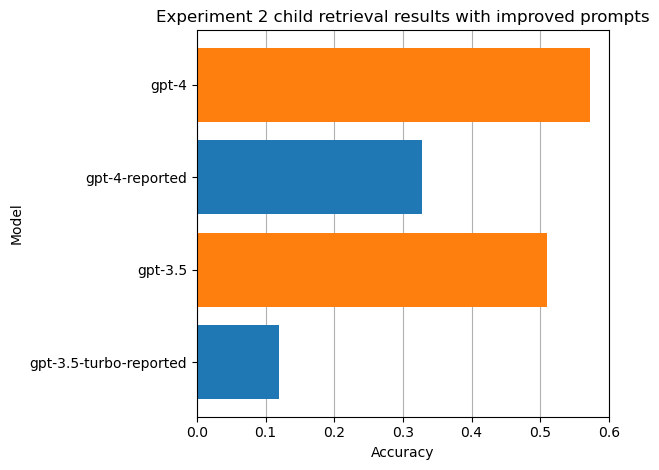

In [8]:
# plot bar chart comparing the reported and new results
# rotate so bars are horizontal
plt.rc("axes", axisbelow=True)
plt.barh(
    list(accuracies.keys()),
    list(accuracies.values()),
    color=["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"],
)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Experiment 2 child retrieval results with improved prompts")
plt.grid(axis="x")
plt.tight_layout()
plt.show()